Importing all needed packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.interpolate import CubicSpline,interp1d,InterpolatedUnivariateSpline
import time
import math as m
import copy
from scipy.interpolate import interp1d
from joblib import Parallel, delayed
from numba import njit
import tabulate

The following are the model parameters taken from prog 09_07 of Fehr and Kindermann (2017)

In [2]:
# Model parameters
beta = 0.99
alpha = 0.4
delta = 0.019
k0 = 15
A = 2
h0 = 0.53
rho = 0.95
sigma_eps = 0.000049
gamma = 0.5
egam = 1-1/gamma
nu = 0.36
variable_g = True
gy = 0.15

# Numerical parameters
k_l = 10.0 #lower bound for capital
k_u = 40.0 #upper bound for capital
tol = 1e-6 #tolerance for policy function convergence
itermax = 2000

# Computational variables variables
TT = 360
eta_dim = 21 #Number of productivty states
grid_res = 100 #capital grid resolution
verbose = True
n_err = 10000 #

The next cell provides functions to discretize and simulate the AR(1) process of the shock plus our policy update function for the policy function iteration algorithm.

In [3]:
def discretize_AR(rho, mu, sigma_eps, n, return_stationary_dist=False):
    """
    Discretizes an AR(1) process using the Rouwenhorst method.

    Args:
        rho:           AR(1) coefficient
        mu:            unconditional mean
        sigma_eps:     std. dev. of the shock
        n:             number of grid points
        return_stationary_dist: if True, returns the stationary distribution

    Returns:
        z:  (n,) grid of discrete values
        pi: (n,n) Markov transition matrix
        w:  (n,) stationary distribution (if requested)
    """
    def rouwenhorst_matrix(rho, n):
        p = (1. + rho) / 2.
        if n == 2:
            return np.array([[p, 1 - p],
                             [1 - p, p]])
        else:
            Pi_n_minus_1 = rouwenhorst_matrix(rho, n - 1)
            Pi = np.zeros((n, n))
            Pi[:-1, :-1]   += p      * Pi_n_minus_1
            Pi[:-1, 1:]    += (1-p)  * Pi_n_minus_1
            Pi[1:, :-1]    += (1-p)  * Pi_n_minus_1
            Pi[1:, 1:]     += p      * Pi_n_minus_1
            Pi[1:-1, :]   /= 2.
            return Pi

    sigma_eta = sigma_eps / (1 - rho**2)
    pi = rouwenhorst_matrix(rho, n)

    psi = np.sqrt(n - 1) * m.sqrt(sigma_eta)
    z = np.zeros(n)
    for i in range(n):
        z[i] = -psi + 2*psi*i/(n-1) + mu

    # Find stationary distribution by repeated multiprlication with the transition vector to find stationary distribution
    if return_stationary_dist:
        w = np.ones(n) / n
        for _ in range(10000):
            w = pi.T @ w
        return z, pi, w
    else:
        return z, pi


def simulate_AR(pi, T, seed):
    """
    Simulates a Markov process using a transition matrix (0-based indexing).

    Parameters
    ----------
    pi : ndarray of shape (n, n)
        Transition matrix where each row sums to 1.
    T : int
        Number of periods to simulate.
    fixed : bool, optional
        Whether to set a fixed random seed for reproducibility.

    Returns
    -------
    shocks : ndarray of int
        Simulated state indices (0-based).
    """
    np.random.seed(seed)

    n = pi.shape[0]
    assert pi.shape[0] == pi.shape[1], "Transition matrix must be square"

    shocks = np.zeros(T, dtype=int)
    shocks[0] = n // 2  # 0-based: start in middle state
    for t in range(1, T):
        shocks[t] = get_tomorrow(pi[shocks[t - 1]])
    return shocks


def get_tomorrow(row_pi):
    """
    Draws a state index (0-based) from a probability row.

    Parameters
    ----------
    row_pi : ndarray of shape (n,)
        Transition probabilities from current state.

    Returns
    -------
    idx : int
        Next state index (0-based).
    """
    rand = np.random.rand()
    cum_probs = np.cumsum(row_pi)
    return np.searchsorted(cum_probs, rand)

def policy_update(j, g, grid_k, grid_eta, coeff_temp, RHS_temp, l, c_new, boost=0):
    fa = foc(1e-10, grid_k[j], g, coeff_temp, RHS_temp, j)
    fb = foc(1-1e-10, grid_k[j], g, coeff_temp, RHS_temp, j)
#    plot_foc_diagnostic(j, g, grid_k, grid_eta, coeff_temp, RHS_temp)
    if fa * fb > 0:
        print(f"Warning: No root at grid_k[{j}]={grid_k[j]:.3f} and eta[{g}]={grid_eta[g]:.3f}: FOC at min={fa:.3e}, max={fb:.3e}, iteration={it}")
        l_star = l[j, g]
        # fallback: assign the feasible endpoint (often max or min, or previous c[i])
    else:
#        try:
        sol = root_scalar(foc, args=(grid_k[j], g, coeff_temp, RHS_temp, j), bracket=[1e-6, 1-1e-6], method='brentq')
        if sol.converged:
            l_star = sol.root
#                if l_star >= 1:
#                    l_star = 1
#                if l_star <= 0:
#                    l_star =1e-10
        else:
            print("No convergengence")
            l_star = l[j, g]
#        except Exception:
            print("No convergengence")
            l_star = l[j, g]
    # Calculate optimal consumption
    l_star = l_star + (l[j, g]-l_star)*boost #Step boost to speed up convergence
    c_star = nu/(1-nu)*(1-l_star)*(1-tau[j,g])*np.exp(grid_eta[g])*(1-alpha)*(grid_k[j]/l_star)**alpha
    return l_star, c_star
    
def plot_rhs_diagnostic(RHS, grid_k):
    plt.figure(figsize=(8,4))
    for g in range(eta_dim):
        plt.plot(grid_k, RHS[:,g], label=f"eta[{g}]")
    plt.xlabel("k")
    plt.ylabel("RHS")
    plt.title("RHS across k for selected eta")
    plt.legend()
    plt.show()

def plot_foc_diagnostic(j, g, grid_k, grid_eta, spline_rhs, rhs_):
    l_grid = np.linspace(1e-5, 1-1e-5, 200)
    foc_vals = [foc(l, grid_k[j], g, spline_rhs, rhs_, j) for l in l_grid]

    plt.figure(figsize=(8,4))
    plt.plot(l_grid, foc_vals, label=f"k={grid_k[j]:.2f}, eta={grid_eta[g]:.2f}")
    plt.axhline(0, color="black", linestyle="--")
    plt.xlabel("Labor l")
    plt.ylabel("FOC(l)")
    plt.title(f"FOC(l) for k={grid_k[j]:.2f}, eta={grid_eta[g]:.2f}")
    plt.legend()
    plt.show()

The following functions summarize the optimality conditions from the model to get the optimal amount of labor for a given capital stock k and productivty state eta. It is split into three functions in order to use Numba to increase speed.

In [4]:

##############################Function to interpolate RHS and to solve the model##############################################################################################
@njit
def compute_rhs_numba(consumption, labor, eta, grid_k, pi, beta, nu, alpha, egam, delta, gamma):
    grid_res, eta_dim = consumption.shape
    RHS = np.zeros((grid_res, eta_dim))
    marg_util = nu * (consumption ** nu * (1 - labor)**(1 - nu))**egam / consumption
    k_over_labor = grid_k[:, None] / labor
    term2 = np.exp(eta)[None, :] * alpha * (k_over_labor ** (alpha - 1))
    term3 = (1-delta) + term2 
    for g in range(eta_dim):
        for k in range(grid_res):
            rhs_vec = pi[g, :] * term3[k, :] * marg_util[k, :]
            RHS[k, g] = beta * np.sum(rhs_vec)
    RHS = RHS ** (-gamma)
    return RHS

def interpolate_RHS(consumption, labor, eta, dim=3):
    RHS = compute_rhs_numba(consumption, labor, eta, grid_k, pi, beta, nu, alpha, egam, delta, gamma)
    if dim == 1:
        coeff_r = [interp1d(grid_k, RHS[:, g], kind='linear', fill_value='extrapolate', assume_sorted=True) for g in range(eta_dim)]
    elif dim == 3:
        coeff_r = [CubicSpline(grid_k, RHS[:, g], bc_type='natural', extrapolate=True) for g in range(eta_dim)]
    else:
        raise ValueError("dim must be 1 (linear) or 3 (cubic)")
    return RHS, coeff_r

def foc(l, k, g, spline_rhs, rhs_, j):
    l = max(min(l,1-1e-10),1e-10)
    

    if variable_g:
        gov = gy * np.exp(grid_eta[g]) * k**alpha * l**(1-alpha)
    else:
        gov = g_level


    # Calculate future capital from capital and labor income
    r = np.exp(grid_eta[g])*alpha*(l/k)**(1-alpha) - delta
    w = np.exp(grid_eta[g])*(1-alpha)*(k/l)**(alpha)
    tau[j, g] = min(1,max(gov/(w*l),-1))
    c_act = nu/(1-nu)*(1-l)*(1-tau[j, g])*w
    kplus = (r+1)*k + (1-tau[j, g])*(w*l) - c_act

    # Evaluate spline at min(kplus, k_u)
    spline = spline_rhs[g]
    k_eval = max(k_l,min(kplus, k_u))
    foc_val = spline_rhs[g](k_eval)

    # Linear extrapolation for kplus > k_u
    if kplus > k_u:
        diff = (rhs_[grid_res-1, g] - rhs_[grid_res-2, g]) / (grid_k[grid_res-1] - grid_k[grid_res-2])
        foc_val += diff * (kplus - k_u)
    if kplus < k_l:
        diff = (rhs_[1, g] - rhs_[0, g]) / (grid_k[1]-grid_k[0])
        foc_val += diff * (kplus - k_l)
    foc_val = foc_val**(-1/gamma)

    # The first order condition
    return nu * (c_act**nu * (1-l)**(1-nu))**egam / c_act - foc_val

In the next cell we setup the grid and the policy functions. As the initial guess we use the same as program prog_09_07 by Fehr and Kindermann (2017)

In [8]:
# Create grid with shocks and transition matrix
grid_eta, pi = discretize_AR(rho, 0, sigma_eps, eta_dim, return_stationary_dist=False)

# Create the grid for k and define policy function
grid_k = np.linspace(k_l, k_u, grid_res)
###############################Initialize policy functions ############################################################################################
l = np.zeros((grid_res, eta_dim))
c = np.zeros((grid_res, eta_dim))
c_new = np.zeros((grid_res, eta_dim))
tau = np.zeros((grid_res, eta_dim))

for i in range(eta_dim):  #create a policy function for every state eta
    l[:,i] = 0.3
    c[:,i] = np.exp(grid_eta[i]) * ((grid_k)**alpha) * (l[:,i])**(1-alpha)
    c_new[:,i] = copy.deepcopy(c[:,i])

In [19]:
#############################Functions for moments ###############################################################
def mean_x(x):
    T = len(x) - 1
    return np.sum(x) / (T + 1)

def coef_var(x):
    T = len(x) - 1
    mu_x = mean_x(x)
    variance = (1 / T) * np.sum((x - mu_x)**2)
    return np.sqrt(variance) / mu_x

def correlation(x, y):
    T = len(x) - 1
    mu_x = mean_x(x)
    mu_y = mean_x(y)
    sigma_x = np.sqrt((1 / T) * np.sum((x - mu_x)**2))
    sigma_y = np.sqrt((1 / T) * np.sum((y - mu_y)**2))
    cov = (1 / T) * np.sum((x - mu_x) * (y - mu_y))
    return cov / (sigma_x * sigma_y)

def bc_statistics(c_t, i_t, k_t, l_t, r_t, w_t, y_t, g_t, tau_t):
    TT = len(c_t) - 1

    tau_min = min(tau_t)
    tau_max = max(tau_t)

    # calculate expectations
    E_c = np.sum(c_t) / (TT + 1)
    E_i = np.sum(i_t) / (TT + 1)
    E_k = np.sum(k_t) / (TT + 1)
    E_l = np.sum(l_t) / (TT + 1)
    E_r = np.sum(r_t) / (TT + 1)
    E_w = np.sum(w_t) / (TT + 1)
    E_y = np.sum(y_t) / (TT + 1)
    E_g = np.sum(g_t) / (TT + 1)
    E_tau = np.sum(tau_t) / (TT + 1)

    # normalization on annual level
    E_k = E_k / 4.0
    E_r = (1.0 + E_r) ** 4 - 1.0

    # calculate coefficient of variation
    CV_c = coef_var(c_t)
    CV_i = coef_var(i_t)
    CV_k = coef_var(k_t)
    CV_l = coef_var(l_t)
    CV_r = coef_var(r_t)
    CV_w = coef_var(w_t)
    CV_y = coef_var(y_t)
    CV_g = coef_var(g_t)
    CV_tau = coef_var(tau_t)

    # calculate correlation coefficients of logs
    Cor_c = correlation(c_t, y_t)
    Cor_i = correlation(i_t, y_t)
    Cor_k = correlation(k_t, y_t)
    Cor_l = correlation(l_t, y_t)
    Cor_r = correlation(r_t, y_t)
    Cor_w = correlation(w_t, y_t)
    Cor_g = correlation(g_t, y_t)
    Cor_tau = correlation(tau_t, y_t)

    return {
        'E_c': E_c, 'E_i': E_i, 'E_k': E_k, 'E_l': E_l, 'E_r': E_r, 'E_w': E_w, 'E_g': E_g,'E_y': E_y, 'E_tau': E_tau,
        'CV_c': CV_c, 'CV_i': CV_i, 'CV_k': CV_k, 'CV_l': CV_l, 'CV_r': CV_r, 'CV_w': CV_w, 'CV_y': CV_y,'CV_g': CV_g,'CV_tau': CV_tau,
        'Cor_c': Cor_c, 'Cor_i': Cor_i, 'Cor_k': Cor_k, 'Cor_l': Cor_l, 'Cor_r': Cor_r, 'Cor_w': Cor_w,'Cor_g': Cor_g,'Cor_tau': Cor_tau,
        'tau_min': tau_min,'tau_max': tau_max
    }

def print_bc_statistics(stats):
    headers = ["", "c", "i", "k", "l", "r", "w", "g", "tau", "y"]
    row_names = ["Mean", "CV (in % of CV of GDP)", "Corr. with GDP"]
    table = [
        [
            stats['E_c'] / stats['E_y'] * 100,
            stats['E_i'] / stats['E_y'] * 100,
            stats['E_k'] / stats['E_y'] * 100,
            stats['E_l'] * 100,
            stats['E_r'] * 100,
            stats['E_w'],
            stats['E_g'] / stats['E_y'] * 100,
            stats['E_tau'] * 100,
            stats['E_y']
        ],
        [
            stats['CV_c'] / stats['CV_y'],
            stats['CV_i'] / stats['CV_y'],
            stats['CV_k'] / stats['CV_y'],
            stats['CV_l'] / stats['CV_y'],
            stats['CV_r'] / stats['CV_y'],
            stats['CV_w'] / stats['CV_y'],
            stats['CV_g'] / stats['CV_g'],
            stats['CV_tau'] / stats['CV_tau']
        ],
        [
            stats['Cor_c'],
            stats['Cor_i'],
            stats['Cor_k'],
            stats['Cor_l'],
            stats['Cor_r'],
            stats['Cor_w'],
            stats['Cor_g'],
            stats['Cor_tau']
        ]
    ]
    print(f"Maximale Steuer {stats['tau_max']:.2f}, Minimale Steuer {stats['tau_min']:.2f}")
    print("\n\nBUSINESS CYCLE MOMENTS")
    print("{:<25s}{:>8s}{:>8s}{:>8s}{:>8s}{:>8s}{:>8s}{:>8s}{:>8s}{:>8s}".format(*headers))
    for name, row in zip(row_names, table):
        print("{:<25s}".format(name) + "".join("{:8.2f}".format(x) for x in row))

########################## Function to simulate economy#######################################################################
##############################################################################################################################
def simulate_econ(l_com, c_com, TT, k0, grid_eta, pi, variable_g=True):
    eta_t = np.zeros(TT)
    shock_series = simulate_AR(pi, TT, 1011)
    c_interp = [CubicSpline(grid_k, c_com[:, g], bc_type='natural', extrapolate=True) for g in range(eta_dim)]
    l_interp = [CubicSpline(grid_k, l_com[:, g], bc_type='natural', extrapolate=True) for g in range(eta_dim)]
    k_t = np.zeros(TT)
    g_t = np.zeros(TT)
    l_t = np.zeros(TT)
    r_t = np.zeros(TT)
    w_t = np.zeros(TT)
    c_t = np.zeros(TT)
    i_t = np.zeros(TT)
    y_t = np.zeros(TT)
    tau_t = np.zeros(TT)
    k_t[0] = k0
    eta_t[0] = grid_eta[shock_series[0]]
    c_t[0] = c_interp[3](k_t[0])
    l_t[0] = l_interp[3](k_t[0])
    y_t[0] = np.exp(eta_t[0])*k_t[0]**alpha*l_t[0]**(1-alpha)
    if variable_g:
        g_t[0] = gy*y_t[0]
    else:
        g_t[0] = g_level
    r_t[0] = np.exp(eta_t[0])*alpha*(l_t[0]/k_t[0])**(1-alpha) - delta
    w_t[0] = np.exp(eta_t[0])*(1-alpha)*(k_t[0]/l_t[0])**(alpha)
    tau_t[0] = g_t[0]/(w_t[0]*l_t[0])
    i_t[0] = y_t[0] - c_t[0] - g_t[0]
    for it in range(1, TT):
        state = shock_series[it]
        eta_t[it] = grid_eta[state]
        k_t[it] = min(40,(1-delta)*k_t[it-1] + i_t[it-1])
        c_t[it] = c_interp[state](k_t[it])
        l_t[it] = l_interp[state](k_t[it])
        y_t[it] = np.exp(eta_t[it])*k_t[it]**alpha*l_t[it]**(1-alpha)
        if variable_g:
            g_t[it] = gy*y_t[it]
        else:
            g_t[it] = stats_var_g['E_g']
        i_t[it] = y_t[it] - c_t[it] - g_t[it]
        r_t[it] = np.exp(eta_t[it])*alpha*(l_t[it]/k_t[it])**(1-alpha) - delta
        w_t[it] = np.exp(eta_t[it])*(1-alpha)*(k_t[it]/l_t[it])**(alpha)
        tau_t[it] = g_t[it]/(w_t[it]*l_t[it])
    econ = [eta_t, k_t, c_t, l_t, y_t, g_t, i_t, r_t, w_t, tau_t]
    return econ

In the following block we solve the model using policy function iteration for variable government consumption

Iteration    1, Convergence level:   0.13539859, Improvement: -86.46%, Time to convergence: 34.70 seconds
Iteration    2, Convergence level:   0.02869213, Improvement: -78.81%, Time to convergence: 12.54 seconds
Iteration    3, Convergence level:   0.02721422, Improvement: -5.15%, Time to convergence: 430.70 seconds
Iteration    4, Convergence level:   0.02582644, Improvement: -5.10%, Time to convergence: 436.11 seconds
Iteration    5, Convergence level:   0.02451693, Improvement: -5.07%, Time to convergence: 540.58 seconds
Iteration    6, Convergence level:   0.02327640, Improvement: -5.06%, Time to convergence: 348.94 seconds
Iteration    7, Convergence level:   0.02209757, Improvement: -5.06%, Time to convergence: 359.32 seconds
Iteration    8, Convergence level:   0.02097474, Improvement: -5.08%, Time to convergence: 453.22 seconds
Iteration    9, Convergence level:   0.01990341, Improvement: -5.11%, Time to convergence: 380.79 seconds
Iteration   10, Convergence level:   0.0188800

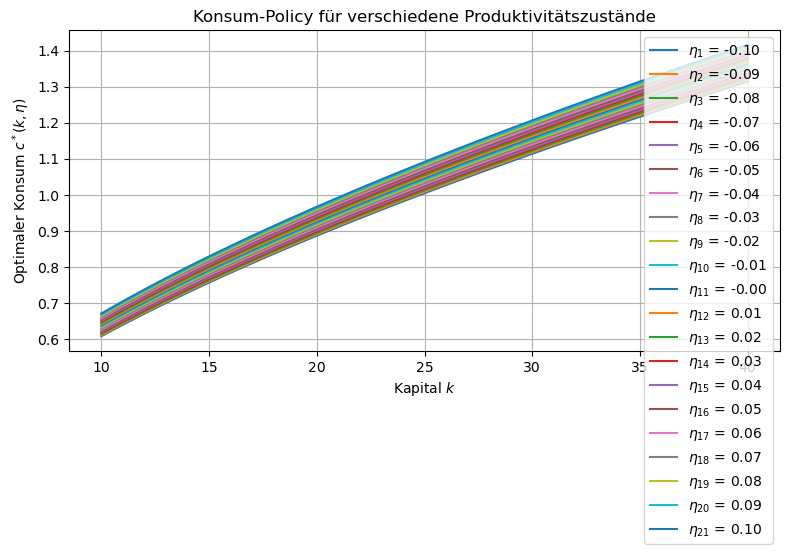

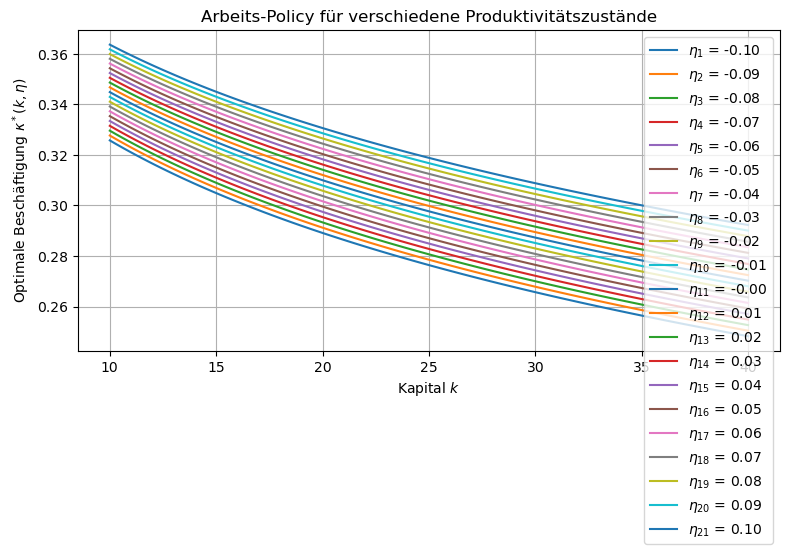

In [10]:
###################################Variable Government spendings ######################################################
variable_g = True
# Use timer to measure convergence time
t0 = time.time()
con_lev = 1
t_con = time.time()
lower = True
for it in range(itermax):
    ############################Interpolate policy functions#########################################################################
    RHS_temp, coeff_temp = interpolate_RHS(c_new, l, grid_eta, 1)
#    plot_rhs_diagnostic(RHS_temp, grid_k)
    
    results = Parallel(n_jobs=-1)(
        delayed(policy_update)(j, g, grid_k, grid_eta, coeff_temp, RHS_temp, l, c_new, boost=0)
        for j in range(grid_res) for g in range(eta_dim))
    

    # Unpack results
    for idx, (l_star, c_star) in enumerate(results):
        j, g = divmod(idx, eta_dim)
        l[j, g] = l_star
        c_new[j, g] = c_star
            
    # Convergence check for the objective function
    diff = np.abs(c_new - c) / np.maximum(np.abs(c_new), 1e-10)
    con_lev_old = con_lev
    con_lev = np.max(diff)
    if verbose:
        elapsed = time.time() - t_con
        t_con = time.time()
        step = con_lev/con_lev_old
        ttc = (np.log(tol/con_lev)/np.log(step)) *elapsed
        improvement = -(1-step)*100
        print(f"Iteration {it+1:4d}, Convergence level: {con_lev:12.8f}, Improvement: {improvement:.2f}%, Time to convergence: {ttc:.2f} seconds")

    if con_lev < tol:
        print(f"Converged after {it+1} iterations")
        elapsed = time.time() - t0
        print(f"Time to convergence: {elapsed:.2f} seconds")
        break


    c = c_new.copy()

    # Plot für Konsumfunktion c_new
    #plt.figure(figsize=(8,5))
    #for g in range(eta_dim):
    #    plt.plot(grid_k, c[:, g], label=fr'$\eta_{{{g+1}}}$ = {grid_eta[g]:.2f}')
    #plt.xlabel(r'Kapital $k$')
    #plt.ylabel(r'Optimaler Konsum $c^*(k,\eta)$')
    #plt.title('Konsum-Policy für verschiedene Produktivitätszustände')
    #plt.legend()
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show()
    
    #plt.figure(figsize=(8,5))
    #for g in range(eta_dim):
    #    plt.plot(grid_k, l[:, g], label=fr'$\eta_{{{g+1}}}$ = {grid_eta[g]:.2f}')
    #plt.xlabel(r'Kapital $k$')
    #plt.ylabel(r'Optimale Beschäftigung $\kappa^*(k,\eta)$')
    #plt.title('Arbeits-Policy für verschiedene Produktivitätszustände')
    #plt.legend()
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show()
else:
    print("No convergence")

plt.figure(figsize=(8,5))
for g in range(eta_dim):
    plt.plot(grid_k, c_new[:, g], label=fr'$\eta_{{{g+1}}}$ = {grid_eta[g]:.2f}')
plt.xlabel(r'Kapital $k$')
plt.ylabel(r'Optimaler Konsum $c^*(k,\eta)$')
plt.title('Konsum-Policy für verschiedene Produktivitätszustände')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
for g in range(eta_dim):
    plt.plot(grid_k, l[:, g], label=fr'$\eta_{{{g+1}}}$ = {grid_eta[g]:.2f}')
plt.xlabel(r'Kapital $k$')
plt.ylabel(r'Optimale Beschäftigung $\kappa^*(k,\eta)$')
plt.title('Arbeits-Policy für verschiedene Produktivitätszustände')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
#Saving the resulting policy functions for variable government consumption
c_gov_var = copy.deepcopy(c_new)
l_gov_var = copy.deepcopy(l)

In [13]:
#Simulating the economy for variable government consumption and printing the Business cycle statistics
TT = 35000
k0 = 25
econ_var_g = simulate_econ(l_gov_var, c_gov_var, TT, k0, grid_eta, pi, variable_g=True)
stats_var_g = bc_statistics(econ_var_g[2], econ_var_g[6], econ_var_g[1], econ_var_g[3], econ_var_g[7], econ_var_g[8], econ_var_g[4], econ_var_g[5], econ_var_g[9])
print_bc_statistics(stats_var_g)

Maximale Steuer 0.25, Minimale Steuer 0.25


BUSINESS CYCLE MOMENTS
                                c       i       k       l       r       w       g     tau       y
Mean                        58.87   26.13  343.77   30.06    4.10    3.45   15.00   25.00    1.73
CV (in % of CV of GDP)       0.69    1.98    0.94    0.34    2.04    0.76    1.00    1.00
Corr. with GDP               0.90    0.94    0.73    0.79    0.44    0.96    1.00   -0.07


Now we solve the model for constant government consumption.

In [14]:
###############################Initialize policy functions ############################################################################################
l = np.zeros((grid_res, eta_dim))
c = np.zeros((grid_res, eta_dim))
c_new = np.zeros((grid_res, eta_dim))
tau = np.zeros((grid_res, eta_dim))

for i in range(eta_dim):  #create a policy function for every state eta
    l[:,i] = 0.3
    c[:,i] = np.exp(grid_eta[i]) * ((grid_k)**alpha) * (l[:,i])**(1-alpha)
    c_new[:,i] = copy.deepcopy(c[:,i])

Iteration    1, Convergence level: 16483594555.95373726, Improvement: 1648359455495.37%, Time to convergence: -3.75 seconds
Iteration    2, Convergence level: 163440762.30822405, Improvement: -99.01%, Time to convergence: 23.92 seconds
Iteration    3, Convergence level:   1.00000000, Improvement: -100.00%, Time to convergence: 2.37 seconds
Iteration    4, Convergence level:   1.00000000, Improvement: -0.00%, Time to convergence: 120088787919.66 seconds
Iteration    5, Convergence level:   1.00000000, Improvement: -0.00%, Time to convergence: 102399327432.43 seconds
Iteration    6, Convergence level:   1.00000000, Improvement: -0.00%, Time to convergence: 69874506983.64 seconds
Iteration    7, Convergence level:   1.00000000, Improvement: -0.00%, Time to convergence: 58253411933.86 seconds
Iteration    8, Convergence level:   1.00000000, Improvement: -0.00%, Time to convergence: 43625796871.61 seconds
Iteration    9, Convergence level:   1.00000000, Improvement: -0.00%, Time to converge

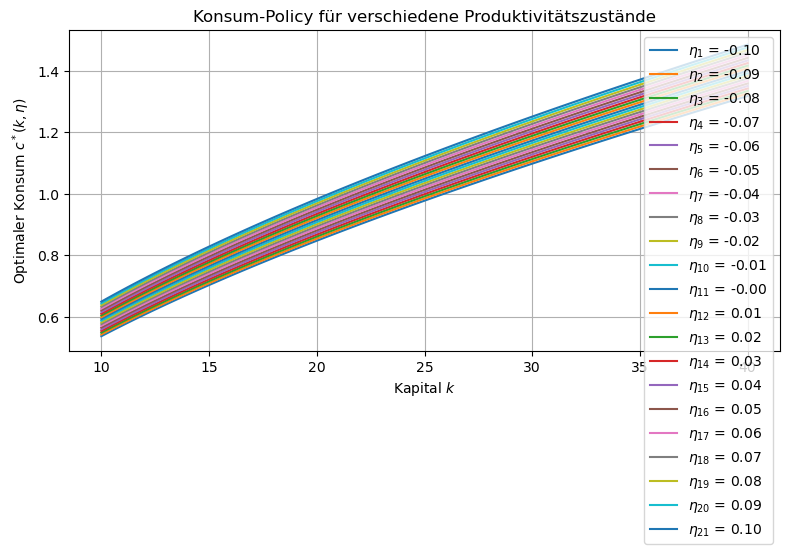

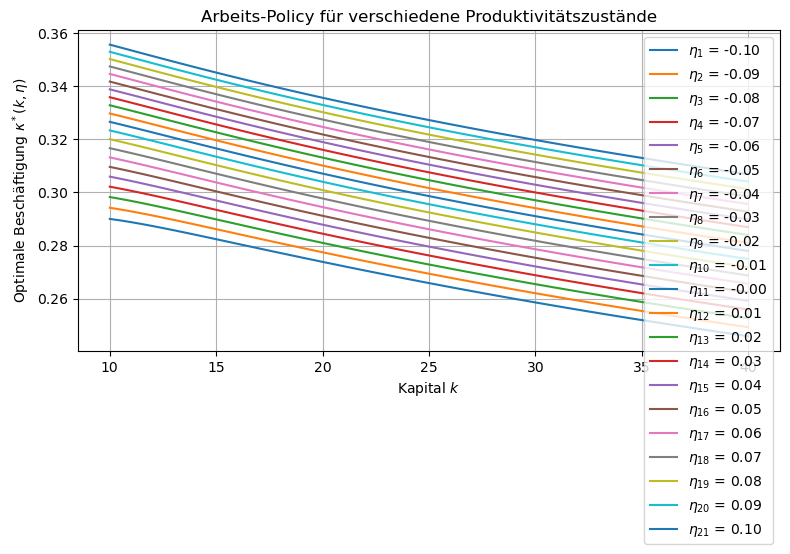

In [15]:
###############################Constant gov consumption ############################################################################
############ For the constant consumption the lower bracket of the root-finding method needed to be raised, as there are to roots within (0,1)
###########The first one is very close to 0 and leads our root finder to fail as the boudaries of the bracket do not have opposite signs

# Use timer to measure convergence time
t0 = time.time()
con_lev = 1
t_con = time.time()
variable_g = True
g_level = stats_var_g['E_g']

def policy_update(j, g, grid_k, grid_eta, coeff_temp, RHS_temp, l, c_new, boost=0):
    k = grid_k[j]
    # Step 1: Grid labor interval for sign changes in FOC
    l_min, l_max = 1e-10, 1-1e-10
    l_grid = np.linspace(l_min, l_max, 100)
    foc_vals = [foc(lv, k, g, coeff_temp, RHS_temp, j) for lv in l_grid]
    root_intervals = []
    for idx in range(len(l_grid)-1):
        if np.sign(foc_vals[idx]) != np.sign(foc_vals[idx+1]):
            root_intervals.append((l_grid[idx], l_grid[idx+1]))
    # Step 2: Find all roots
    roots = []
    for (a, b) in root_intervals:
        try:
            sol = root_scalar(foc, args=(k, g, coeff_temp, RHS_temp, j), bracket=[a, b], method='brentq')
            if sol.converged:
                roots.append(sol.root)
        except Exception:
            pass
    if len(roots) > 0:
        l_star = max(roots)
    else:
        l_star = l_max
    l_star = l_star + (l[j, g]-l_star)*boost # Optional boost for convergence
    # --- recompute tau for l_star ---
    w = np.exp(grid_eta[g])*(1-alpha)*(k/l_star)**alpha
    gov = g_level
    tau_local = min(1,max(gov/(w*l_star),-1))
    c_star = nu/(1-nu)*(1-l_star)*(1-tau_local)*np.exp(grid_eta[g])*(1-alpha)*(k/l_star)**alpha
    return l_star, c_star
    
def foc(l, k, g, spline_rhs, rhs_, j):
    l = max(min(l,1-1e-10),1e-10)
    
    #gov = gy * np.exp(grid_eta[g]) * k**alpha * l**(1-alpha)
    gov = g_level


    # Calculate future capital from capital and labor income
    r = np.exp(grid_eta[g])*alpha*(l/k)**(1-alpha) - delta
    w = np.exp(grid_eta[g])*(1-alpha)*(k/l)**(alpha)
    #print(gov/(w*l))
    tau_temp = min(1,max(gov/(w*l),-1))
    c_act = nu/(1-nu)*(1-l)*(1-tau_temp)*w
    kplus = (r+1)*k + (1-tau_temp)*(w*l) - c_act

    # Evaluate spline at min(kplus, k_u)
    spline = spline_rhs[g]
    k_eval = max(k_l,min(kplus, k_u))
    foc_val = spline_rhs[g](k_eval)

    # Linear extrapolation for kplus > k_u
    if kplus > k_u:
        diff = (rhs_[grid_res-1, g] - rhs_[grid_res-2, g]) / (grid_k[grid_res-1] - grid_k[grid_res-2])
        foc_val += diff * (kplus - k_u)
    if kplus < k_l:
        diff = (rhs_[1, g] - rhs_[0, g]) / (grid_k[1]-grid_k[0])
        foc_val += diff * (kplus - k_l)
    foc_val = foc_val**(-1/gamma)

    # The first order condition
    return nu * (c_act**nu * (1-l)**(1-nu))**egam / c_act - foc_val



for it in range(itermax):
    ############################Interpolate policy functions#########################################################################
    RHS_temp, coeff_temp = interpolate_RHS(c_new, l, grid_eta, 1)
#    plot_rhs_diagnostic(RHS_temp, grid_k)
    
    results = Parallel(n_jobs=-1)(
        delayed(policy_update)(j, g, grid_k, grid_eta, coeff_temp, RHS_temp, l, c_new, boost=0)
        for j in range(grid_res) for g in range(eta_dim))
    

    # Unpack results
    for idx, (l_star, c_star) in enumerate(results):
        j, g = divmod(idx, eta_dim)
        l[j, g] = l_star
        c_new[j, g] = c_star
            
    # Convergence check for the objective function
    diff = np.abs(c_new - c) / np.maximum(np.abs(c_new), 1e-10)
    con_lev_old = con_lev
    con_lev = np.max(diff)
    if verbose:
        elapsed = time.time() - t_con
        t_con = time.time()
        step = con_lev/con_lev_old
        ttc = (np.log(tol/con_lev)/np.log(step)) *elapsed
        improvement = -(1-step)*100
        print(f"Iteration {it+1:4d}, Convergence level: {con_lev:12.8f}, Improvement: {improvement:.2f}%, Time to convergence: {ttc:.2f} seconds")

    if con_lev < tol:
        print(f"Converged after {it+1} iterations")
        elapsed = time.time() - t0
        print(f"Time to convergence: {elapsed:.2f} seconds")
        break


    c = c_new.copy()

    # Plot für Konsumfunktion c_new
    #plt.figure(figsize=(8,5))
    #for g in range(eta_dim):
    #    plt.plot(grid_k, c[:, g], label=fr'$\eta_{{{g+1}}}$ = {grid_eta[g]:.2f}')
    #plt.xlabel(r'Kapital $k$')
    #plt.ylabel(r'Optimaler Konsum $c^*(k,\eta)$')
    #plt.title('Konsum-Policy für verschiedene Produktivitätszustände')
    #plt.legend()
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show()
    
    #plt.figure(figsize=(8,5))
    #for g in range(eta_dim):
    #    plt.plot(grid_k, l[:, g], label=fr'$\eta_{{{g+1}}}$ = {grid_eta[g]:.2f}')
    #plt.xlabel(r'Kapital $k$')
    #plt.ylabel(r'Optimale Beschäftigung $\kappa^*(k,\eta)$')
    #plt.title('Arbeits-Policy für verschiedene Produktivitätszustände')
    #plt.legend()
    #plt.grid(True)
    #plt.tight_layout()
    #plt.show()
else:
    print("No convergence")

plt.figure(figsize=(8,5))
for g in range(eta_dim):
    plt.plot(grid_k, c_new[:, g], label=fr'$\eta_{{{g+1}}}$ = {grid_eta[g]:.2f}')
plt.xlabel(r'Kapital $k$')
plt.ylabel(r'Optimaler Konsum $c^*(k,\eta)$')
plt.title('Konsum-Policy für verschiedene Produktivitätszustände')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
for g in range(eta_dim):
    plt.plot(grid_k, l[:, g], label=fr'$\eta_{{{g+1}}}$ = {grid_eta[g]:.2f}')
plt.xlabel(r'Kapital $k$')
plt.ylabel(r'Optimale Beschäftigung $\kappa^*(k,\eta)$')
plt.title('Arbeits-Policy für verschiedene Produktivitätszustände')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

l_gov_const = copy.deepcopy(l)
c_gov_const = copy.deepcopy(c_new)


In [21]:
TT = 35000
k0 = 25
econ_const_g = simulate_econ(l_gov_const, c_gov_const, TT, k0, grid_eta, pi, variable_g=False)
stats_const_g = bc_statistics(econ_const_g[2], econ_const_g[6], econ_const_g[1], econ_const_g[3], econ_const_g[7], econ_const_g[8], econ_const_g[4], econ_const_g[5], econ_const_g[9])
print_bc_statistics(stats_const_g)

Maximale Steuer 0.29, Minimale Steuer 0.21


BUSINESS CYCLE MOMENTS
                                c       i       k       l       r       w       g     tau       y
Mean                        58.86   26.14  344.02   30.06    4.10    3.45   14.99   25.04    1.73
CV (in % of CV of GDP)       0.88    2.12    1.06    0.43    2.06    0.68    1.00    1.00
Corr. with GDP               0.93    0.94    0.76    0.84    0.27    0.94    0.00   -1.00


In previous attempts we had some issues getting viable results for constant government consumption. The foc did not return valid values or fell back to the fallback option for almost most points. We later identified with a variation of the following code, that there are two roots within l = (0,1). As the lower root leads to a diverging behavior of the algorithm and a collapse of capital we realized that the larger root is the optimal one and adjusted our algorithm.

0.3153830013581616 0.022
0.230242118661943 0.022894472361809044
0.1741875035868041 0.02378894472361809
0.13476108845681561 0.024683417085427133
0.10567313266595293 0.025577889447236178
0.08342355535369997 0.026472361809045226
0.06591960836902264 0.02736683417085427
0.05183614398407066 0.028261306532663316
0.0402952255971297 0.02915577889447236
0.030693039219341245 0.030050251256281406
0.022601389439526998 0.03094472361809045
0.015709088729288417 0.031839195979899496
0.009784053834196144 0.032733668341708544
0.004650028247084492 0.033628140703517585
0.00017083292190750443 0.034522613065326634
-0.0037603562598756968 0.035417085427135675
-0.007228476051461569 0.03631155778894472
-0.010301889703607486 0.03720603015075377
-0.01303648007699365 0.03810050251256281
-0.015477639035799878 0.038994974874371854
-0.017663254332401762 0.0398894472361809
-0.019624995918231275 0.04078391959798995
-0.02138953582546471 0.041678391959799
-0.022979492549990876 0.04257286432160804
-0.024414169714211426 0.0

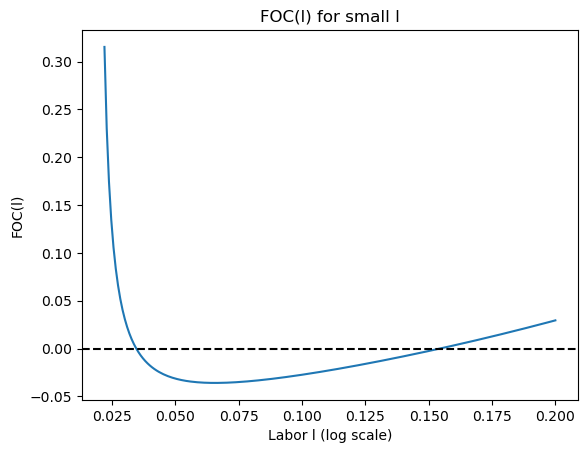

In [17]:
###############################Initialize policy functions ############################################################################################
l = np.zeros((grid_res, eta_dim))
c = np.zeros((grid_res, eta_dim))
c_new = np.zeros((grid_res, eta_dim))
tau = np.zeros((grid_res, eta_dim))


for i in range(eta_dim):  #create a policy function for every state eta
    l[:,i] = 0.3
    c[:,i] = np.exp(grid_eta[i]) * ((grid_k)**alpha) * (l[:,i])**(1-alpha)
    c_new[:,i] = copy.deepcopy(c[:,i])

def foc(l, k, g, spline_rhs, rhs_, j):
    #l = max(min(l,1-1e-10),1e-10)
    
    #gov = gy * np.exp(grid_eta[g]) * k**alpha * l**(1-alpha)
    gov = 0.26


    # Calculate future capital from capital and labor income
    r = np.exp(grid_eta[g])*alpha*(l/k)**(1-alpha) - delta
    w = np.exp(grid_eta[g])*(1-alpha)*(k/l)**(alpha)
    #print(gov/(w*l))
    tau_temp = min(1,max(gov/(w*l),-1))
    c_act = nu/(1-nu)*(1-l)*(1-tau_temp)*w
    kplus = (r+1)*k + (1-tau_temp)*(w*l) - c_act

    # Evaluate spline at min(kplus, k_u)
    spline = spline_rhs[g]
    k_eval = max(k_l,min(kplus, k_u))
    foc_val = spline_rhs[g](k_eval)

    # Linear extrapolation for kplus > k_u
    if kplus > k_u:
        diff = (rhs_[grid_res-1, g] - rhs_[grid_res-2, g]) / (grid_k[grid_res-1] - grid_k[grid_res-2])
        foc_val += diff * (kplus - k_u)
    if kplus < k_l:
        diff = (rhs_[1, g] - rhs_[0, g]) / (grid_k[1]-grid_k[0])
        foc_val += diff * (kplus - k_l)
    foc_val = foc_val**(-1/gamma)

    # The first order condition
    print(nu * (c_act**nu * (1-l)**(1-nu))**egam / c_act - foc_val, l)
    return nu * (c_act**nu * (1-l)**(1-nu))**egam / c_act - foc_val
RHS_temp, coeff_temp = interpolate_RHS(c_new, l, grid_eta, 1)
l_grid = np.linspace(0.022, 0.2, 200)  # from 1e-8 to 0.1
foc_vals = [foc(l, grid_k[j], g, coeff_temp, RHS_temp, j) for l in l_grid]
plt.plot(l_grid, foc_vals)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Labor l (log scale)")
plt.ylabel("FOC(l)")
plt.title("FOC(l) for small l")
plt.show()

In [28]:
###############################Welfare Analysis#####################################################################
c_const = econ_const_g[2]
c_var   = econ_var_g[2]
l_const = econ_const_g[3]
l_var   = econ_var_g[3]

WE_c = [np.mean(c_const), np.mean(c_var)]
WE_leis = [np.mean(1.0 - l_const), np.mean(1.0 - l_var)]
WCV_c = [np.std(c_const) / max(np.abs(np.mean(c_const)), 1e-10),
         np.std(c_var)   / max(np.abs(np.mean(c_var)),   1e-10)]
WCV_leis = [np.std(1.0 - l_const) / max(np.abs(np.mean(1.0 - l_const)), 1e-10),
            np.std(1.0 - l_var)   / max(np.abs(np.mean(1.0 - l_var)),   1e-10)]
WCor_leis = [np.corrcoef(c_const, 1.0 - l_const)[0,1],
             np.corrcoef(c_var,   1.0 - l_var)[0,1]]

W_lev = np.zeros(2)
W_c = np.zeros(2)
W_leis = np.zeros(2)
W_cor = np.zeros(2)
W_tot = np.zeros(2)
util = np.zeros(2)

bar_nu = (1.0 - nu) * nu * gamma

for ii in range(2):
    util[ii]   = (WE_c[ii] ** nu * WE_leis[ii] ** (1.0 - nu)) ** egam / egam
    W_lev[ii]  = 1.0 / (nu * egam)
    W_c[ii]    = -1.0 / (2.0 * nu * gamma) * (nu**2 + bar_nu) * WCV_c[ii]**2
    W_leis[ii] = -1.0 / (2.0 * nu * gamma) * ((1.0 - nu)**2 + bar_nu) * WCV_leis[ii]**2
    W_cor[ii]  = -1.0 / (nu * gamma) * (nu * (1.0 - nu) - bar_nu) * WCor_leis[ii] * WCV_c[ii] * WCV_leis[ii]
    W_tot[ii]  = W_lev[ii] + W_c[ii] + W_leis[ii] + W_cor[ii]

uhat     = util[1] / util[0]
Del_lev  = uhat * W_lev[1]  - W_lev[0]
Del_c    = uhat * W_c[1]    - W_c[0]
Del_leis = uhat * W_leis[1] - W_leis[0]
Del_cor  = uhat * W_cor[1]  - W_cor[0]
Del_tot  = uhat * W_tot[1]  - W_tot[0]

print("\nWELFARE ANALYSIS\n")
print("                     LEVEL       CV(c)         CV(l)      RHO(c,l)       TOTAL")
print(f"Constant g:   {util[0]:12.5f} {WCV_c[0]:12.5f} {WCV_leis[0]:12.5f} {WCor_leis[0]:12.5f}")
print(f"Variable g:   {util[1]:12.5f} {WCV_c[1]:12.5f} {WCV_leis[1]:12.5f} {WCor_leis[1]:12.5f}")
print("Aprox. cost:  {:12.5f} {:12.5f} {:12.5f} {:12.5f} {:12.5f}".format(
    Del_lev*100, Del_c*100, Del_leis*100, Del_cor*100, Del_tot*100))


WELFARE ANALYSIS

                     LEVEL       CV(c)         CV(l)      RHO(c,l)       TOTAL
Constant g:       -1.24964      0.04057      0.00848     -0.58365
Variable g:       -1.24977      0.02638      0.00560     -0.43874
Aprox. cost:      -0.02837      0.06460      0.00592     -0.00871      0.03344
